* Requisite imports + models

In [1]:
# importing all 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

First, we format df and try to drop nulls/correct and scale the data

In [3]:
#load data
df = pd.read_csv('dataalt.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


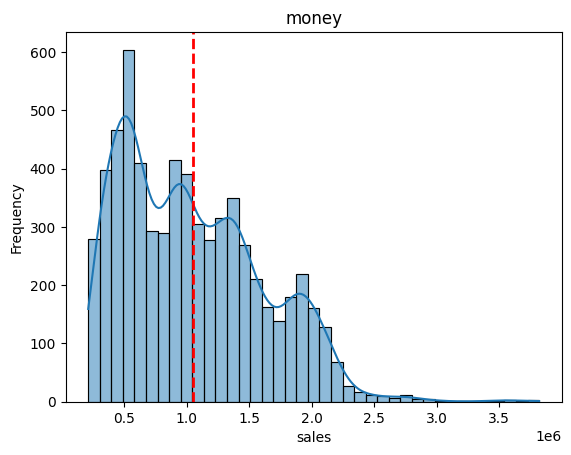

In [5]:
#checking the target variables for distribution
sns.histplot(df['Weekly_Sales'], kde=True)
plt.axvline(x=df['Weekly_Sales'].mean(), linestyle='--', linewidth=2, color='red')
plt.title('money')  
plt.xlabel('sales')
plt.ylabel('Frequency')
plt.show()

the plot shows that there's a definite left skew to the graph, accompanied by infrequent outliers which necessitate scaling

In [6]:

#describe df to get a better overview
df.describe()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [5]:
# dealing with missing data and min-max scaling

df['date'] = pd.to_datetime(df['date'])
df['years_since_renovation'] = np.where(df['yr_renovated'] == 0, 0, df['date'].dt.year - df['yr_renovated'])
df['house_age'] = df['date'].dt.year - df['yr_built']

df['years_since_renovation'] = np.where(df['yr_renovated'] == 0, 0, df['date'].dt.year - df['yr_renovated'])
df['date'] = (df['date'].astype('int64') / (24 * 3600)).round() * (24 * 3600)

df[['zipstring', 'zipcode']] = df['statezip'].str.split(' ', expand=True)
df.drop(columns= ['street','statezip', 'zipstring', 'country'], inplace= True)


In [6]:
from sklearn.impute import SimpleImputer

num_cols = [col for col in df.columns if df[col].dtype in ['float64','int64']]
cat_cols = [col for col in df.columns if df[col].dtype not in ['float64','int64']]

df[num_cols] = SimpleImputer().fit_transform(df[num_cols])
df[num_cols] = MinMaxScaler().fit_transform(df[num_cols])
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output = False).fit(df[cat_cols])
encoded_cols = list(encoder.get_feature_names_out(cat_cols))
df_encoded = pd.DataFrame(
    encoder.fit_transform(df[cat_cols]), 
    columns=encoder.get_feature_names_out(cat_cols), 
    index=df.index
)

df = pd.concat([df.drop(columns=cat_cols), df_encoded], axis=1)

In [ ]:

#using .corr() to identify areas/data with highest corellation
corr = df.corr()
corr_filtered = corr.where(corr >= 0.3, np.nan)
# Identify columns where all correlations are below 0.3
cols_to_drop = [col for col in corr_filtered.columns if corr_filtered[col].isna().all()]
df_cleaned = df.drop(columns=cols_to_drop)

# Print the cleaned data
print(df_cleaned)

# Optionally, plot the heatmap again with the filtered correlations
plt.figure(figsize=(30, 9))
sns.heatmap(corr_filtered, annot=True)
# Save the heatmap as a JPG file
plt.savefig('heatmap.jpg', format='jpg')


In [8]:
y = df_cleaned['price']
X = df_cleaned.drop('price', axis=1)  # All columns except 'price'


using OneHotEncoder for strings-> narrow down data

see https://www.reddit.com/r/datascience/comments/145d04o/label_encoding_for_categorical_columns_xgboost/

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.2,
                                                 random_state=42)

In [10]:
num_cols.remove('price')
X_train[num_cols] = SimpleImputer().fit_transform(X_train[num_cols])
X_train[num_cols] = MinMaxScaler().fit_transform(X_train[num_cols])
X_test[num_cols] = SimpleImputer().fit_transform(X_test[num_cols])
X_test[num_cols] = MinMaxScaler().fit_transform(X_test[num_cols])

In [11]:
# copypasted optimizing
import optuna


'''

def objective(trial, data = inputs_df[numeric_cols + encoded_cols],target = targets):
    
    #x, y = inputs_df[numeric_cols + encoded_cols], targets
    X_train,X_test,y_train,y_test = train_test_split(
    inputs_df[numeric_cols + encoded_cols], targets, test_size=0.25, random_state=42)
    param = {
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': trial.suggest_categorical('n_estimators', [1000,2000,3000,4000]),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = XGBRegressor(**param)  
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    preds_valid = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds_valid, squared=False)
    return rmse

    
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

study.best_params

'''
#taking best params
best_params = {'lambda': 3.559040735218393,
 'alpha': 0.25772549522868987,
 'colsample_bytree': 0.6,
 'subsample': 0.5,
 'learning_rate': 0.014,
 'n_estimators': 4000,
 'max_depth': 11,
 'random_state': 24,
 'min_child_weight': 3}


In [12]:

#making dictionary of models
models = {
    'SVR':SVR(),
    'XGBRegressor':XGBRegressor(),
    'XGBR':XGBRegressor(**best_params),
    'Ridge':Ridge(),
    'ElasticNet':ElasticNet(),
    'SGDRegressor':SGDRegressor(),
    'BayesianRidge':BayesianRidge(),
    'LinearRegression':LinearRegression(),
    'RandomForestRegressor':RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor()
}

In [ ]:
#taking results from the models
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse**0.5
    r2 = r2_score(y_test, y_pred)
    results.append([name, r2, mse, rmse])

results_df = pd.DataFrame(results, columns=['Model', 'R-squared', 'MSE', 'RMSE'])
results_df = results_df.sort_values(by='R-squared', ascending=False).reset_index(drop=True)
print(results_df)

from this, we can conclusively say that the most accurate model in this case would be BayesianRidge, with highest r-squared and lowest MSE/RMSE

Credit: 
https://www.kaggle.com/code/heyrobin/house-price-prediction-beginner-s-notebook
